In [74]:
!pip install pm4py

drive = True
dir = './data/'
if drive:
  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

  import sys
  sys.path.insert(0,'/content/drive/My Drive/Masterthesis')

  dir = '/content/drive/My Drive/Masterthesis/'

import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import pm4py


def import_xes(file_path):
    event_log = pm4py.read_xes(file_path)
    event_log['time:timestamp'] = pd.to_datetime(event_log['time:timestamp'], utc=True)
    return event_log


event_log_path = 'data/Sepsis.xes'

Mounted at /content/drive


In [75]:
# Read event_log from XES file and preprocess
event_log = import_xes(dir + event_log_path)

parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

In [76]:
event_log

,InfectionSuspected,org:group,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,concept:name,...,DiagnosticLacticAcid,lifecycle:transition,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,case:concept:name,Leucocytes,CRP,LacticAcid
0,True,A,True,True,True,True,True,True,True,ER Registration,...,True,complete,A,False,True,True,A,NaN,NaN,NaN
1,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,...,NaN,complete,NaN,NaN,NaN,NaN,A,9.6,NaN,NaN
2,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,21.0,NaN
3,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LacticAcid,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,2.2
4,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15209,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,KNA,NaN,66.0,NaN
15210,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Release A,...,NaN,complete,NaN,NaN,NaN,NaN,KNA,NaN,NaN,NaN
15211,False,L,False,False,False,False,False,False,False,ER Registration,...,False,complete,NaN,False,False,False,LNA,NaN,NaN,NaN
15212,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,NaN,complete,NaN,NaN,NaN,NaN,LNA,NaN,NaN,NaN


In [77]:
# cols specifies the attributes which should be taken into account to compute the uniqueness
def compute_uniqueness(df, cols):
    amount_cases = df.shape[0]
    unique_values_in_column = df[cols].drop_duplicates().shape[0]
    uniqueness_of_col = round(unique_values_in_column / amount_cases, 4) * 100
    return uniqueness_of_col

In [78]:
# Now let's focus on the uniqueness of traces
case_identifier = 'case:concept:name'
event_identifier = 'concept:name'
df_events_per_case = event_log[[case_identifier, event_identifier]]
df_events_per_case['count_events'] = event_log.groupby(case_identifier)[case_identifier].transform('count')
df_events_per_case = df_events_per_case.drop(event_identifier, axis=1)
df_events_per_case = df_events_per_case.drop_duplicates()

events = event_log.groupby(case_identifier)[event_identifier].agg(lambda x: ', '.join(str(val).strip() for val in x if pd.notna(val))).reset_index()
events.columns = [case_identifier, 'events']
df_events_per_case = pd.merge(df_events_per_case, events, on=case_identifier, how='left')

df_events_per_case

<ipython-input-78-3b0efca8e3df>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events_per_case['count_events'] = event_log.groupby(case_identifier)[case_identifier].transform('count')


,case:concept:name,count_events,events
0,A,22,"ER Registration, Leucocytes, CRP, LacticAcid, ..."
1,B,12,"ER Registration, ER Triage, CRP, LacticAcid, L..."
2,C,14,"ER Registration, ER Triage, ER Sepsis Triage, ..."
3,D,13,"ER Registration, ER Triage, ER Sepsis Triage, ..."
4,E,8,"ER Registration, ER Triage, ER Sepsis Triage, ..."
...,...,...,...
1045,HNA,30,"ER Registration, ER Triage, ER Sepsis Triage, ..."
1046,INA,3,"ER Registration, ER Triage, ER Sepsis Triage"
1047,JNA,3,"ER Registration, ER Triage, ER Sepsis Triage"
1048,KNA,15,"ER Registration, ER Triage, ER Sepsis Triage, ..."


In [79]:
uniqueness_of_traces = compute_uniqueness(df_events_per_case, 'events')
print("Overall trace uniqueness: {} %".format(uniqueness_of_traces))

Overall trace uniqueness: 80.57 %


In [80]:
# Compute the uniqueness of each activity --> With which probability can I reidentify a case (trace) given that a specific activity is contained in the trace
total_amount_traces = df_events_per_case.shape[0]
total_amount_events = event_log[event_identifier].unique().shape[0]
all_events = event_log[event_identifier].unique()
uniqueness_containing_activity = pd.DataFrame(all_events, columns=['events'])
counts = {}
appears = {}

def helper_count(row, activity_code):
    total_counts = str(row).count(str(activity_code))
    return 1 if total_counts > 0 else 0

for event in all_events:
    counts[str(event)] = int(df_events_per_case['events'].apply(lambda row: str(row).count(str(event))).values.sum())
    appears[str(event)] = df_events_per_case['events'].apply(lambda row: helper_count(row, event)).values.sum()

df_unique_events = pd.DataFrame([counts.keys(), counts.values(), appears.values()]).T
df_unique_events.columns = [event_identifier, 'total counts', 'containedInTrace']

# Compute uniqueness
df_unique_events['uniqueness'] = 1 - (df_unique_events['containedInTrace'] - 1) / total_amount_traces

print(df_unique_events.sort_values('uniqueness', ascending=False))

        concept:name total counts containedInTrace uniqueness
15         Release E            6                6   0.995238
14         Release D           24               24   0.978095
13         Release C           25               25   0.977143
12         Release B           56               56   0.947619
11      Admission IC          117              110    0.89619
10         Return ER          294              294   0.720952
9          Release A          671              671   0.361905
6          IV Liquid          753              753    0.28381
8       Admission NC         1182              800   0.239048
7     IV Antibiotics          823              823   0.217143
3         LacticAcid         1466              860   0.181905
2                CRP         3262             1007   0.041905
1         Leucocytes         3383             1012   0.037143
5   ER Sepsis Triage         1049             1049   0.001905
0    ER Registration         1050             1050   0.000952
4       

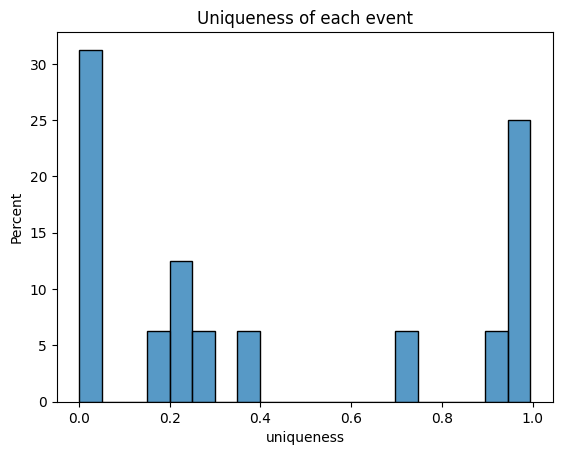

Bin 1 -  Count: 5, Percentage: 31.25 %
Bin 2 -  Count: 0, Percentage: 0.0 %
Bin 3 -  Count: 0, Percentage: 0.0 %
Bin 4 -  Count: 1, Percentage: 6.25 %
Bin 5 -  Count: 2, Percentage: 12.5 %
Bin 6 -  Count: 1, Percentage: 6.25 %
Bin 7 -  Count: 0, Percentage: 0.0 %
Bin 8 -  Count: 1, Percentage: 6.25 %
Bin 9 -  Count: 0, Percentage: 0.0 %
Bin 10 -  Count: 0, Percentage: 0.0 %
Bin 11 -  Count: 0, Percentage: 0.0 %
Bin 12 -  Count: 0, Percentage: 0.0 %
Bin 13 -  Count: 0, Percentage: 0.0 %
Bin 14 -  Count: 0, Percentage: 0.0 %
Bin 15 -  Count: 1, Percentage: 6.25 %
Bin 16 -  Count: 0, Percentage: 0.0 %
Bin 17 -  Count: 0, Percentage: 0.0 %
Bin 18 -  Count: 0, Percentage: 0.0 %
Bin 19 -  Count: 1, Percentage: 6.25 %
Bin 20 -  Count: 4, Percentage: 25.0 %

0 activities are completely unique


In [81]:
def print_and_visualize_hist_plot(df, col_name, amount_bins, hist_title, total_amount):

    sns.histplot(df[col_name], bins=amount_bins, stat='percent').set(title=hist_title)
    plt.show()

    hist_values, bin_edges = np.histogram(df[col_name], bins=amount_bins)

    # Print out the histogram values
    for i in range(len(hist_values)):
        print(f"Bin {i+1} -  Count: {hist_values[i]}, Percentage: {round(hist_values[i]/total_amount, 4) * 100} %")

    # Count of activities which have a uniqueness of 100%
    amount_completely_unique_activities = df[df[col_name] == 1][col_name].count()
    print("\n{} activities are completely unique".format(amount_completely_unique_activities))

print_and_visualize_hist_plot(df=df_unique_events, col_name='uniqueness', amount_bins=20, hist_title='Uniqueness of each event',total_amount=total_amount_events)

In [82]:
# unique traces in the event log not considering the order of execution of the activities and how many times each activity was executed

df_activites_per_case_as_set = df_events_per_case
# Convert String to list, then to set to remove duplicates and then convert set back to list to order the elements. Finally, convert list back to a String
df_activites_per_case_as_set['events ordered'] = df_events_per_case['events'].apply(lambda row: ", ".join(sorted(list(set(row.split(", "))))))

# Compute Uniqueness
unordered_set_uniquness_of_activities = compute_uniqueness(df_activites_per_case_as_set, cols=['events ordered'])
print("{} % of traces are unique not considering the order of execution of the activities and how many times each activity was executed".format(unordered_set_uniquness_of_activities))

6.1899999999999995 % of traces are unique not considering the order of execution of the activities and how many times each activity was executed


In [83]:
data = event_log[case_identifier].drop_duplicates().to_frame()

for col in event_log.columns:
  if col != case_identifier:
    appended_values = event_log.groupby(case_identifier)[col].agg(lambda x: ', '.join(str(val).strip() for val in x if pd.notna(val))).reset_index()
    data = data.merge(appended_values, how='left')

data

,case:concept:name,InfectionSuspected,org:group,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,...,Oligurie,DiagnosticLacticAcid,lifecycle:transition,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Leucocytes,CRP,LacticAcid
0,A,True,"A, B, B, B, C, A, A, A, D, B, B, B, B, B, B, B...",True,True,True,True,True,True,True,...,False,True,"complete, complete, complete, complete, comple...",A,False,True,True,"9.6, 8.7, 9.6, 10.7, 13.0, 11.3, 10.9","21.0, 109.0, 47.0, 15.0, 9.0, 9.0, 6.0",2.2
1,B,True,"A, C, B, B, B, A, A, A, F, B, B, E",True,False,True,False,True,True,False,...,False,True,"complete, complete, complete, complete, comple...",B,False,True,True,13.8,"240.0, 226.0, 75.0",0.8
2,C,True,"A, C, A, B, B, A, A, G, H, B, B, B, B, E",True,False,False,False,True,True,True,...,False,True,"complete, complete, complete, complete, comple...",C,False,True,True,"15.4, 18.1, 7.4","27.0, 186.0, 81.0",
3,D,True,"A, C, A, B, B, B, A, A, F, B, B, E, ?",True,False,True,False,True,True,True,...,False,True,"complete, complete, complete, complete, comple...",D,False,False,True,"7.7, 7.6","171.0, 49.0",1.6
4,E,True,"A, C, A, A, B, B, B, A",True,False,True,False,True,True,True,...,False,True,"complete, complete, complete, complete, comple...",,False,True,True,8.5,265.0,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,HNA,True,"A, C, A, B, B, B, A, W, B, B, B, B, B, B, B, B...",True,False,True,False,True,True,True,...,False,True,"complete, complete, complete, complete, comple...",G,False,True,True,"2.0, 1.8, 3.0, 5.8, 10.7, 12.2, 18.3, 12.0","573.0, 368.0, 358.0, 307.0, 185.0, 152.0, 100....","7.2, 2.8, 1.8, 2.0, 1.4"
1046,INA,False,"A, C, A",False,False,False,False,False,False,False,...,False,False,"complete, complete, complete",,False,False,False,,,
1047,JNA,False,"A, C, A",False,False,False,False,False,False,False,...,False,False,"complete, complete, complete",,False,False,False,,,
1048,KNA,True,"A, C, A, B, B, B, A, A, Q, B, B, B, B, B, E",True,False,True,False,True,True,True,...,False,True,"complete, complete, complete, complete, comple...",QE,False,True,True,"9.4, 8.5, 8.9","267.0, 282.0, 66.0","2.3, 0.2"


In [84]:
from itertools import combinations

cols = data.columns
cols = cols.drop([case_identifier, 'time:timestamp'])

combinations_size_two = list(combinations(cols, 2))
combinations_size_three = list(combinations(cols, 3))

combinations_size_two_uniqueness = {}
combinations_size_three_uniqueness = {}

for combi in combinations_size_two:
  combinations_size_two_uniqueness[combi] = 100 - compute_uniqueness(data, list(combi));

for combi in combinations_size_three:
  combinations_size_three_uniqueness[combi] = 100 - compute_uniqueness(data, list(combi));


<ipython-input-85-7d4fa4b23242>:11: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df_size_two = df_size_two.pivot("Attribute1", "Attribute2", "Uniqueness")


             Attribute1         Attribute2  Uniqueness
0    InfectionSuspected          org:group       24.38
1    InfectionSuspected    DiagnosticBlood       99.62
2    InfectionSuspected         DisfuncOrg       99.71
3    InfectionSuspected  SIRSCritTachypnea       99.62
4    InfectionSuspected         Hypotensie       99.71
..                  ...                ...         ...
430       DiagnosticECG                CRP       18.67
431       DiagnosticECG         LacticAcid       76.57
432          Leucocytes                CRP        4.67
433          Leucocytes         LacticAcid        6.19
434                 CRP         LacticAcid       10.38

[435 rows x 3 columns]


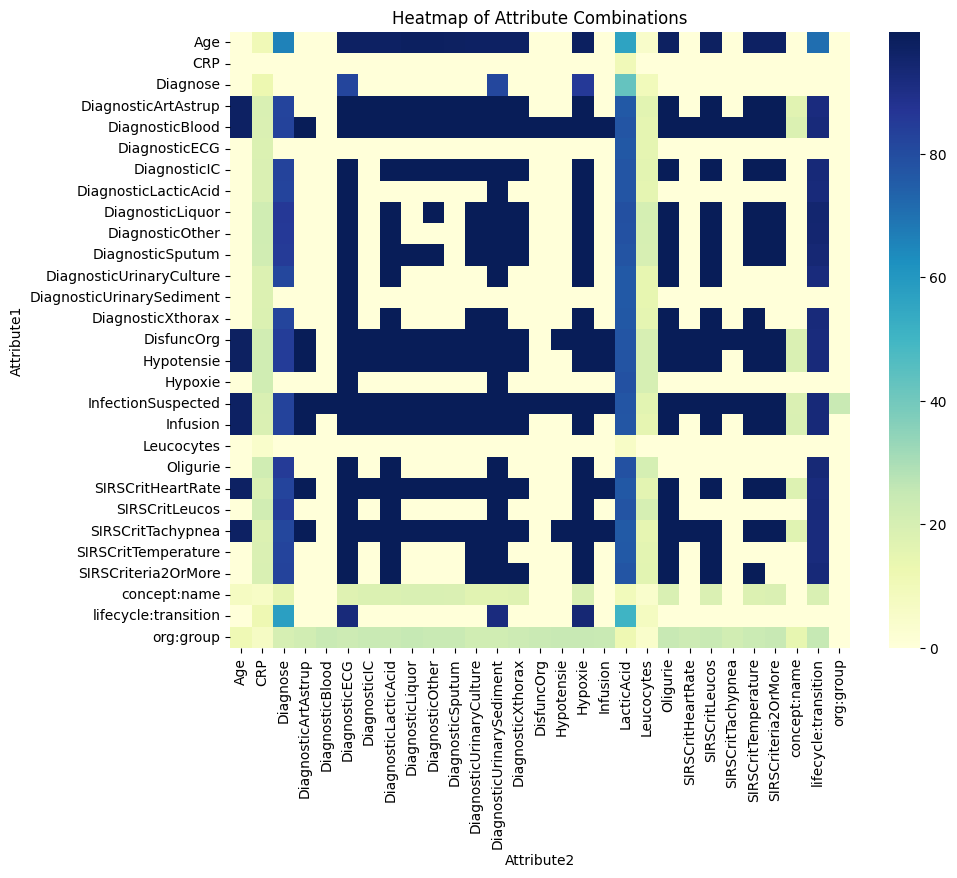

              Attribute1            Attribute2            Attribute3  \
1901          Hypotensie      DiagnosticLiquor   SIRSCriteria2OrMore   
3283    DiagnosticSputum   SIRSCriteria2OrMore               Hypoxie   
3424    DiagnosticLiquor   SIRSCritTemperature              Oligurie   
64    InfectionSuspected            DisfuncOrg      DiagnosticLiquor   
3199        DiagnosticIC              Oligurie  DiagnosticLacticAcid   
...                  ...                   ...                   ...   
3073                 Age              Diagnose            Leucocytes   
3088                 Age            Leucocytes                   CRP   
3067                 Age  lifecycle:transition            Leucocytes   
2746        concept:name                   Age            Leucocytes   
610            org:group                   Age            Leucocytes   

      Uniqueness  
1901       99.62  
3283       99.62  
3424       99.62  
64         99.62  
3199       99.62  
...          ...  
30

In [85]:
data_list_size_two = [{"Attribute1": k[0], "Attribute2": k[1], "Uniqueness": v} for k, v in combinations_size_two_uniqueness.items()]
data_list_size_three = [{"Attribute1": k[0], "Attribute2": k[1], "Attribute3": k[2], "Uniqueness": v} for k, v in combinations_size_three_uniqueness.items()]

df_size_two = pd.DataFrame(data_list_size_two)
df_size_three = pd.DataFrame(data_list_size_three)

df_size_two['Uniqueness'] = pd.to_numeric(df_size_two['Uniqueness'], errors='coerce')
df_size_three['Uniqueness'] = pd.to_numeric(df_size_three['Uniqueness'], errors='coerce')

df_size_two = df_size_two[df_size_two['Uniqueness'] > 0]
pivot_df_size_two = df_size_two.pivot("Attribute1", "Attribute2", "Uniqueness")
pivot_df_size_two_filled = pivot_df_size_two.fillna(0)

print(df_size_two)

# Visualizing using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df_size_two_filled, cmap="YlGnBu")
plt.title("Heatmap of Attribute Combinations")
plt.show()

print(df_size_three.sort_values(by='Uniqueness', ascending=False))

In [102]:
sample_data = data.merge(df_events_per_case, how='left')[[case_identifier, event_identifier, 'count_events', 'time:timestamp', 'Age', 'CRP', 'LacticAcid']]
sample_data


,case:concept:name,concept:name,count_events,time:timestamp,Age,CRP,LacticAcid
0,A,"ER Registration, Leucocytes, CRP, LacticAcid, ...",22,"2014-10-22 11:15:41+00:00, 2014-10-22 11:27:00...",85.0,"21.0, 109.0, 47.0, 15.0, 9.0, 9.0, 6.0",2.2
1,B,"ER Registration, ER Triage, CRP, LacticAcid, L...",12,"2014-12-21 11:04:24+00:00, 2014-12-21 11:17:19...",45.0,"240.0, 226.0, 75.0",0.8
2,C,"ER Registration, ER Triage, ER Sepsis Triage, ...",14,"2014-02-09 19:29:29+00:00, 2014-02-09 20:05:23...",55.0,"27.0, 186.0, 81.0",
3,D,"ER Registration, ER Triage, ER Sepsis Triage, ...",13,"2014-07-10 11:52:00+00:00, 2014-07-10 12:06:24...",70.0,"171.0, 49.0",1.6
4,E,"ER Registration, ER Triage, ER Sepsis Triage, ...",8,"2015-01-15 20:14:58+00:00, 2015-01-15 20:16:03...",75.0,265.0,2.8
...,...,...,...,...,...,...,...
1045,HNA,"ER Registration, ER Triage, ER Sepsis Triage, ...",30,"2014-08-01 10:26:51+00:00, 2014-08-01 10:31:06...",75.0,"573.0, 368.0, 358.0, 307.0, 185.0, 152.0, 100....","7.2, 2.8, 1.8, 2.0, 1.4"
1046,INA,"ER Registration, ER Triage, ER Sepsis Triage",3,"2014-11-03 09:43:47+00:00, 2014-11-03 09:54:47...",25.0,,
1047,JNA,"ER Registration, ER Triage, ER Sepsis Triage",3,"2014-11-12 17:40:19+00:00, 2014-11-12 17:47:25...",40.0,,
1048,KNA,"ER Registration, ER Triage, ER Sepsis Triage, ...",15,"2014-12-11 23:28:38+00:00, 2014-12-11 23:52:48...",35.0,"267.0, 282.0, 66.0","2.3, 0.2"
